# Overall Strategy
![alt text](docs/pipeline.jpg "Title")

The main idea was to make a model as simple as possible without the added complication of heavy preprocessing or postprocessing.

For training the model, I used only one image of a ball which I found using a simple OpenCV function. After this, I pasted the same ball onto background photos I took from Kaggle. I divided the ball into 2 classes: magic-ball and a fixed color circle/ball.

There are other wide-ranging possibilities to perform the task, but I chose this way because, in my understanding, it gives the fastest real-time inference (as you can see, it takes me an average of 70 ms per image) and requires minimal time for pre- and post-processing.

* Step 1 - I chose a simple image with only one magic ball and detected it using HoughCircles (OpenCV).
* Step 2 - I created a new dataset using the copy-paste augmentation.
* Step 3 - I trained a YOLOv8-nano detector to find 2 classes (0: magic ball, 1: regular ball).
* Step 4 - For inference, I used scale TTA and NMS for ensemble.
* Step 5 - For postprocessing, I converted the bounding boxes to circles.

# Datastes and requirements
* kaggle datasets download -d balraj98/stanford-background-dataset & unzip stanford-background-dataset -d stanford-background-dataset
* pip install -U ultralytics
* pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
* pip install numpy opencv-python 
* pip install ensemble-boxes

In [1]:
from IPython.display import clear_output
import torch
import cv2
import numpy as np
import albumentations as A
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import sys
import glob
from tqdm import tqdm
from ultralytics import YOLO
import time
from ensemble_boxes import *
import os

In [2]:
class config:
    magic_ball_for_example = 'Balls/MVC-001F.JPG'
    random_paths = glob.glob('stanford-background-dataset/images/*.jpg')
    MAX_IMAGES = 10000

# step 1 
* find the first magic ball using (medianBlur -> HoughCircles)

In [3]:
def find_ball_with_opencv(path):
    img_rgb = cv2.imread(path)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_b = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img_b,cv2.COLOR_GRAY2BGR)
    circles = cv2.HoughCircles(img_b,cv2.HOUGH_GRADIENT,1,300,param1=100,param2=30,minRadius=0,maxRadius=100)
    circles = np.uint16(np.around(circles))
    for c in circles[0,:]:
        cv2.circle(img_rgb,(c[0],c[1]),c[2],(0,255,0),7)
        cv2.circle(img_rgb,(c[0],c[1]),2,(0,0,255),7)
    bbox = [c[0]-c[2],c[1]-c[2],c[0]+c[2],c[1]+c[2]]
    return img_rgb,bbox

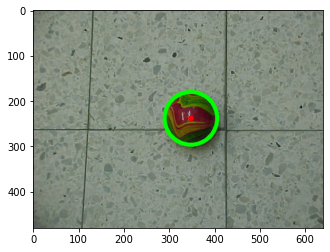

In [4]:
img_rgb,bbox = find_ball_with_opencv(config.magic_ball_for_example)
plt.imshow(img_rgb[:,:,::-1])
plt.show()

# step 2 
* Generate 10000 images with copy paste aug

In [5]:
transform = A.Compose([
    A.ShiftScaleRotate(p=1.0,shift_limit=0.1,scale_limit=0.25,rotate_limit=360,),
    A.Downscale(p=0.75),
    A.GaussianBlur(p=0.75)
])
def gen_random_magic_ball(color_image,transform,min_imgz=64):
    transformed = transform(image=color_image)
    transformed_image = transformed["image"]
    img=Image.fromarray(transformed_image)
    npImage=np.array(img)
    h,w=img.size
    alpha = Image.new('L', img.size,0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice([0,0,h,w],0,360,fill=255)
    npAlpha=np.array(alpha)
    
    if np.random.randint(2)==0:
        npImage=npImage.astype(float) * np.expand_dims(npAlpha.astype(bool).astype(float),-1)
        c = 0
    else:
        npImage=np.ones_like(npImage.astype(float)) * np.expand_dims(npAlpha.astype(bool).astype(float),-1)
        if np.random.randint(4) !=0:
            npImage[:,:,0] *= np.random.randint(256)
            npImage[:,:,1] *= np.random.randint(256)
            npImage[:,:,2] *= np.random.randint(256)
        elif np.random.randint(4) !=0:
            npImage *= np.random.randint(64) 
        else:
            npImage[:,:,1] *= np.random.randint(256)
            npImage[:,:,0] *= 0
            npImage[:,:,2] *= 0
        c=1
    size = min_imgz+np.random.randint(min_imgz)
    return cv2.resize(npImage.astype(np.uint8),(size,size)),c

In [6]:
def get_random_background(random_paths=config.random_paths):
    r_num = np.random.randint(len(random_paths))
    return cv2.imread(random_paths[r_num])

In [7]:
def copy_paste(back_image,img):
    h,w,_ = back_image.shape
    img_gen,c = gen_random_magic_ball(img,transform,min_imgz=min(h,w)//10)
    new_image = np.zeros_like(back_image)
    startY = np.random.randint(h-img_gen.shape[0])
    startX = np.random.randint(w-img_gen.shape[1])
    new_image[startY:startY+img_gen.shape[0],startX:startX+img_gen.shape[1]] = img_gen.copy()
    fg = cv2.bitwise_or(back_image,back_image, mask=(1-new_image.astype(bool)).astype(np.uint8)[:,:,0])
    fg2 = cv2.bitwise_or(new_image,new_image, mask=(new_image.astype(bool)).astype(np.uint8)[:,:,0])
    return fg+fg2,[startX,startY,startX+img_gen.shape[1],startY+img_gen.shape[0],c]

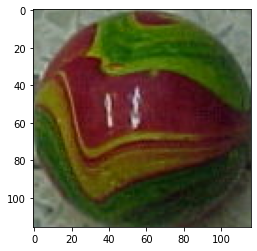

In [8]:
img_ball = cv2.imread(config.magic_ball_for_example)[:,:,::-1]
img_ball = img_ball[bbox[1]:bbox[3],bbox[0]:bbox[2]]
plt.imshow(img_ball)

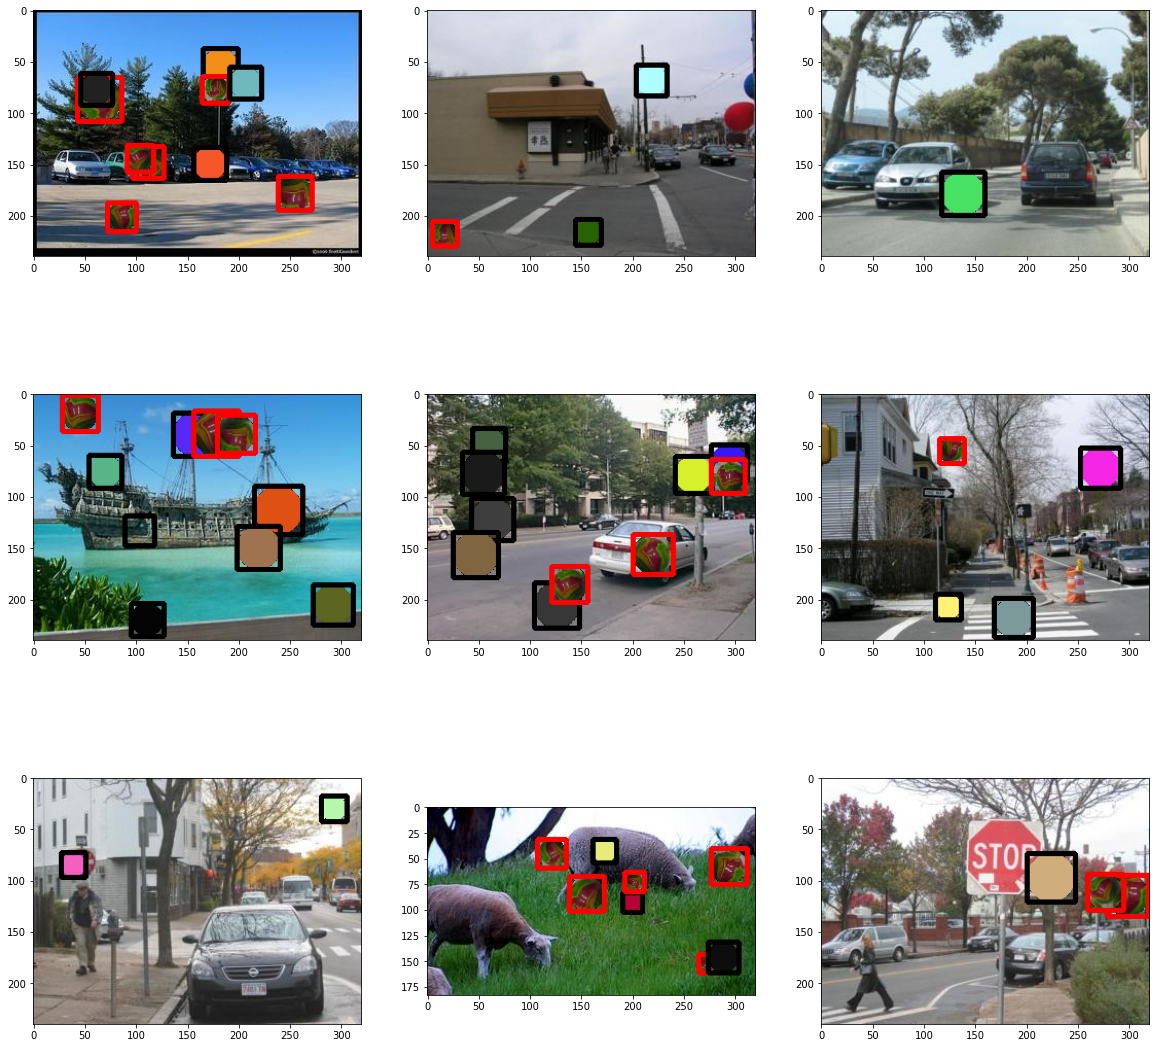

In [9]:
plt.figure(figsize=[20,20])
for row in range(9):
    bboxes = []
    plt.subplot(3,3,row+1)
    results = get_random_background(config.random_paths)[:,:,::-1]
    for _ in range(1+ np.random.randint(10)):
        results,bbox2 = copy_paste(results,img_ball)
        bboxes.append(bbox2)
        if bbox2[-1]==0:
            c = 255
        else:
            c = 0
        cv2.rectangle(results,(bbox2[0],bbox2[1]),(bbox2[2],bbox2[3]),c,4)
    plt.imshow(results)

In [10]:
for num_image in tqdm(range(config.MAX_IMAGES)):
    bboxes = []
    results = get_random_background(random_paths)[:,:,::-1]
    for _ in range(1+ np.random.randint(5)):
        results,bbox2 = copy_paste(results,img_ball)
        bboxes.append(bbox2)
    cv2.imwrite(f"train/{num_image}.jpg",results[:,:,::-1])
    bboxes = np.array(bboxes).astype(float)
    h,w,_ = results.shape
    with open(f'train/{num_image}.txt', 'w+') as f:
        for b in bboxes:
            class_num = b[4]
            norm_w = (b[2]-b[0])/w
            norm_h = (b[3]-b[1])/h
            norm_x_center = b[0]/w + norm_w/2
            norm_y_center = b[1]/h + norm_h/2
            row = [class_num,norm_x_center,norm_y_center,norm_w,norm_h]
            row = np.array(row).astype(float).astype(str)
            text = ' '.join(row)
            f.write(text)
            f.write("\n")

In [11]:
all_data = glob.glob("train/*.jpg")
with open(f'train.txt', 'w+') as f:
    for row in all_data[:config.MAX_IMAGES-200]:
        f.write(row)
        f.write("\n")
with open(f'val.txt', 'w+') as f:
    for row in all_data[config.MAX_IMAGES-200:]:
        f.write(row)
        f.write("\n")

# Train Yolov8 nano

* Train data with mixup and mosaic
![alt text](runs/detect/magic_ball/train_batch0.jpg "Title")

In [12]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt") 
results = model.train(data='ball.yaml', epochs=6, imgsz=640,save=True,exist_ok=True,plots=True,val=True,mixup=0.75,batch=32,close_mosaic=0,name="magic_ball")

Ultralytics YOLOv8.0.145 🚀 Python-3.7.10 torch-1.8.1+cu111 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48640MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=ball.yaml, epochs=6, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=magic_ball, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, fo

## Yolo results
* I trained only 6 epochs because I haven't really validated the datasets, and I try to avoid overfitting.
![alt text](runs/detect/magic_ball/val_batch1_pred.jpg "Title")

# Evaluation
* Using 2Xscale TTA

In [44]:
start_time = time.time()
all_images = []
paths = glob.glob(f"{path}*")
for p in paths:
    s = time.time()
    img = cv2.imread(p)
    h,w,_ = img.shape
    n = max(h,w)+1
    res640 = model(img[:,:,::-1],
                save=False,
                augment=True,
                imgsz=640,
                conf=0.3,
                classes=[0,1],
                exist_ok=True)
    res320 = model(img[:,:,::-1],
                save=False,
                augment=True,
                imgsz=320,
                conf=0.3,
                classes=[0,1],
                exist_ok=True)
    res320 = res320[0].boxes.data.cpu().numpy()/n
    res640 = res640[0].boxes.data.cpu().numpy()/n
    res320 = res320[res320[:, 5].argsort()]
    res640 = res640[res640[:, 5].argsort()]
    if len(res320)==0 and len(res640)!=0:
        boxes_list = [res640[:,:4].tolist()]
        scores_list = [res640[:,4].tolist()]
        labels_list = [res640[:,5].tolist()]
    elif len(res640)==0 and len(res320)!=0:
        boxes_list = [res320[:,:4].tolist()]
        scores_list = [res320[:,4].tolist()]
        labels_list = [res320[:,5].tolist()]
    elif len(res640)!=0 and len(res320)!=0:    
        boxes_list = [res320[:,:4].tolist(),res640[:,:4].tolist()]
        scores_list = [res320[:,4].tolist(),res640[:,4].tolist()]
        labels_list = [res320[:,5].tolist(),res640[:,5].tolist()]
    else:
        all_images.append([p,img,time.time()-s])
        continue
    boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=[1.0,1.0], iou_thr=0.1)
    boxes*=n
    wx = boxes[:,2] - boxes[:,0]
    hy = boxes[:,3] - boxes[:,1]
    xcenter = boxes[:,0] + wx/2
    ycenter = boxes[:,1] + hy/2
    for x,y,ww,hh,l in zip(xcenter,ycenter,wx,hy,labels):
        if ww < 20 or hh<20:
            continue
        raduis = max(ww,hh)
        if l==0:
            cv2.circle(img,(int(x),int(y)),int(raduis/2.0),(200,50,100) if l==0 else (0,255,0),5)
        # else:
        #     cv2.circle(img,(int(x),int(y)),int(5),(255,0,0) if l==0 else (0,255,0),10)
    all_images.append([p,img,time.time()-s])
all_time_p = time.time()-start_time
clear_output()
print(f"cell time: {all_time_p}")

cell time: 0.9948115348815918


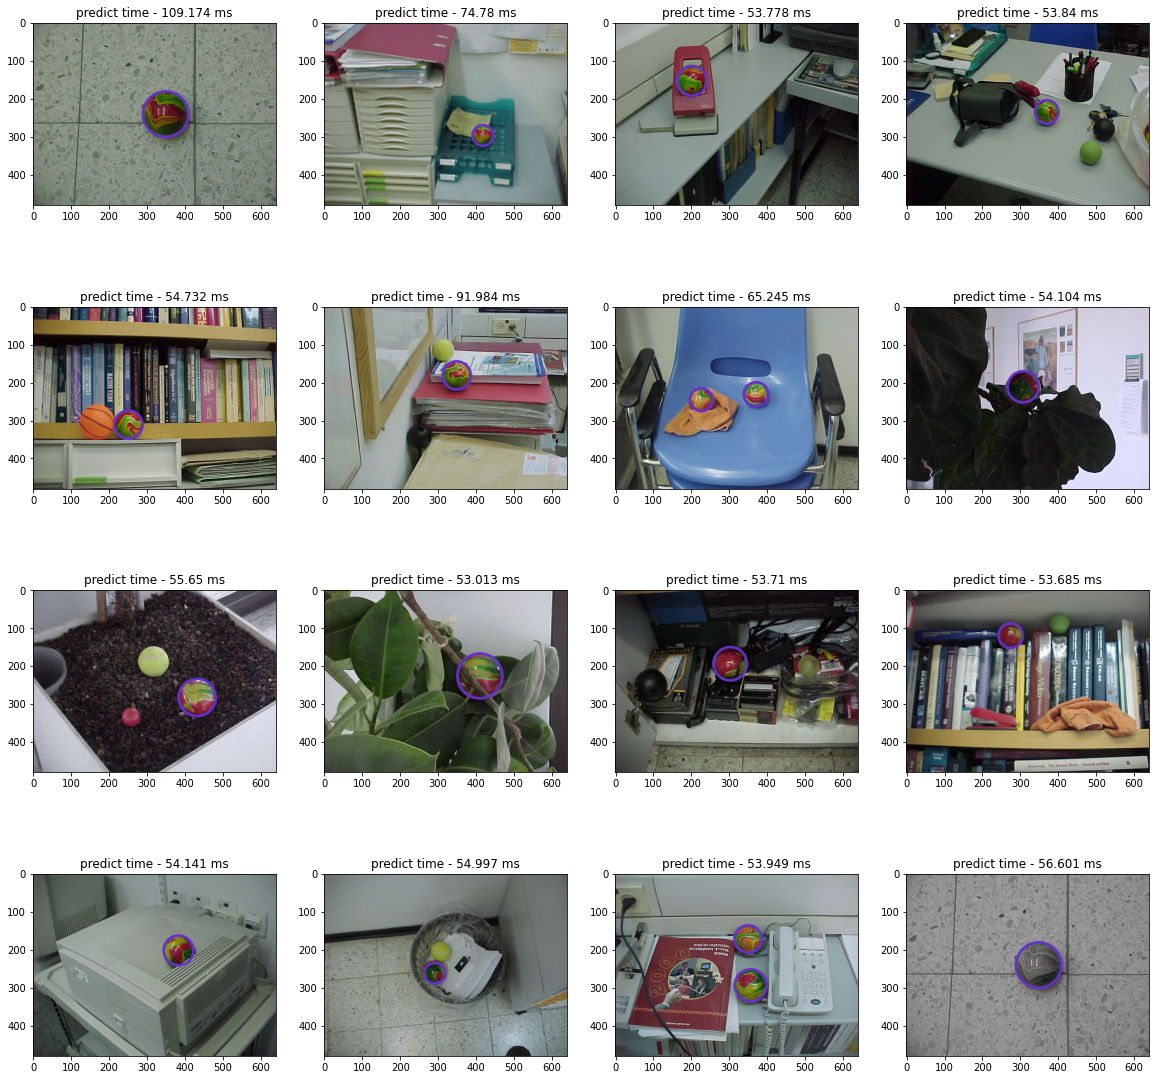

In [45]:
plt.figure(figsize=[20,20])
for i,(p,im,t) in enumerate(all_images):
    plt.subplot(4,4,i+1)
    plt.imshow(im[:,:,::-1])
    plt.title(f"predict time - {round(t*1000,3)} ms")
    cv2.imwrite(p.replace("Balls","results"),im)

# Conclusions
* **According to the plot above, you can see that all the magic balls were found, and no other ball was identified as a magic ball.**
* Apart from one image (MVC-008F.JPG), the bounding box around the magic ball is pretty accurate.

![alt text](./results/MVC-008F.JPG "MVC-008F")

* The model handles a manipulated image well (bonus).

![alt text](./results/challenge_image.png "challenge_image.png")

* The average processing time for one image is 70 milliseconds, while the whole test set of images took 1.12 seconds to process.
* **It is possible to improve the performance dramatically and also make the model better for additional examples by retraining and creating new data using the results of the model (pseudo-labeling). However, I didn't do this because I have no way to measure the quality of the model after this process, as I don't have any more test pictures.**